# 3D trajectory

In this notebook, we construct the 3D trajectories of inner droplets by combining the X-Y plane tracking results and the simultaneous stage positions.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from skimage import io
from IPython.display import clear_output
import dufte
plt.style.use(dufte.style)
from fit_circle_utils import fit_sphere
from myImageLib import bestcolor

In [32]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

## 1 Construct xyz-traj

Save the combined trajectory.

In [127]:
folder = '/home/zhengyang/data/DE/07202021/1st-drop-tracking/2021-07-20_16h25m35s-m2'
stagePosition = pd.read_csv(os.path.join(folder, 'StagePosition.txt'), delimiter='\t',
                            names=['name', 'x', 'y', 'z', 'UK1', 'UK2'])

xyPosition = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'traj.csv'))

xyPosition = xyPosition.set_index('filename')
stagePosition = stagePosition.set_index('name')

In [128]:
mpp = 0.1
ind = intersection(xyPosition.index, stagePosition.index) # find overlap frames
xyPosition = xyPosition.loc[ind] # slice xy data
xyPosition['x'] *= mpp # apply mpp
xyPosition['y'] *= mpp # apply mpp
xyPosition = xyPosition.assign(z=stagePosition['z'].loc[ind])  # concatenate z data to xy data

In [129]:
xyPosition

,x,y,z
filename,,,
21596,41.10,48.98,45.774
21597,41.54,49.46,45.774
21598,41.46,49.24,45.774
21599,41.72,49.40,45.774
21600,41.54,49.60,45.774
...,...,...,...
23396,65.08,47.34,40.433
23397,65.44,47.26,40.243
23398,65.48,47.16,40.243


In [130]:
xyz_traj = xyPosition[['x', 'y', 'z']]
xyz_traj.to_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv'), float_format='%.1f')

## 2 Visualize the trajectory 

In [131]:
xyz_traj = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv')).set_index('filename')
mpp = 0.1 # microns per pixel

### 2.1 In 2D (2d-image.jpg)

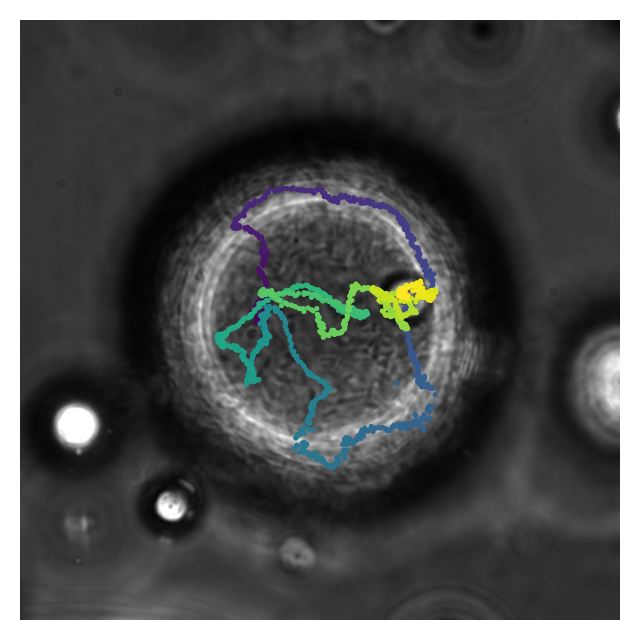

In [133]:
image_folder = os.path.join(folder, 'images')
img = io.imread(os.path.join(image_folder, '{:08d}.tif'.format(xyz_traj.index[-1])))

fig = plt.figure(figsize=(3, 3/img.shape[1]*img.shape[0]), dpi=200)
ax = fig.add_axes([0,0,1,1])
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.scatter(xyz_traj.x/mpp, xyz_traj.y/mpp, s=0.7, c=np.arange(len(xyz_traj))/len(xyz_traj))

fig.savefig(os.path.join(folder, 'crop_HoughCircles', '2d-image.jpg'))

### 2.2 In 3D

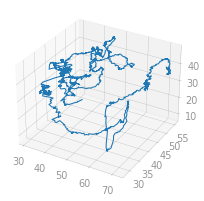

In [125]:
fig = plt.figure(dpi=50)
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz_traj.x, xyz_traj.y, xyz_traj.z)
# ax.set_xlim((0, 102.4))
# ax.set_ylim((102.4, 0))

(0.0, 54.78)

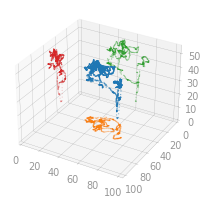

In [126]:
# draw projections

fig = plt.figure(dpi=50)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_traj.x, xyz_traj.y, xyz_traj.z, 
           s=1)
ax.scatter(xyz_traj.x, xyz_traj.y, 0, 
       s=0.5, alpha=0.2)
ax.scatter(xyz_traj.x, 0, xyz_traj.z, 
       s=0.5, alpha=0.2)
ax.scatter(0, xyz_traj.y, xyz_traj.z, 
       s=0.5, alpha=0.2)

ax.set_xlim((0, img.shape[0]*mpp))
ax.set_ylim((img.shape[1]*mpp, 0))
ax.set_zlim((0, 1.1*xyPosition1.z.max()))

## 3 3D trajectory animation 

### 3.1 Fixed view, with projections (3d-traj-animation.avi)

![3d traj projection demo](demo/3d-traj-projection-demo.gif)

In [134]:
# trajectory animation and video
mpp = 0.1 # microns per pixel
interval = 10 # plot skip
save_folder = os.path.join(folder, 'crop_HoughCircles', '3d-traj-animation')
image_folder = os.path.join(folder, 'images')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)

for i in range(len(xyPosition)):
    if i % interval != 0:
        continue
    print('{0:d}/{1:d}, {2:.2f}%'.format(i, len(xyPosition), i/len(xyPosition)*100))
    clear_output(wait=True)
    xyPosition1 = xyz_traj[:i+1]
    zeros = np.zeros(len(xyPosition1))
    fig = plt.figure(figsize=(4, 2), dpi=150)
    ax = fig.add_axes([0,0,0.5,1], projection='3d')
    ax.plot(xyPosition1.x, xyPosition1.y, xyPosition1.z)

    ax.plot(xyPosition1.x, xyPosition1.y, zeros, ls=':')
    ax.plot(xyPosition1.x, zeros, xyPosition1.z, ls=':')
    ax.plot(zeros, xyPosition1.y, xyPosition1.z, ls=':')
    
    img = io.imread(os.path.join(image_folder, '{:08d}.tif'.format(xyPosition1.index[-1])))
    
    # determine axis limits automatically
    ax.set_xlim((0, img.shape[0]*mpp))
    ax.set_ylim((img.shape[1]*mpp, 0))
    ax.set_zlim((0, 1.1*xyPosition1.z.max()))
    
    ax2 = fig.add_axes([0.5,0,0.5,1])    
    ax2.imshow(img, cmap='gray')
    ax2.plot(xyPosition1.x.iloc[-1]/mpp, xyPosition1.iloc[-1].y/mpp, 
             mec='red', ls='', marker='o', mfc=(0,0,0,0), markersize=11)
    ax2.axis('off')
    fig.savefig(os.path.join(save_folder, '{:08d}.jpg'.format(xyPosition1.index[-1])))
    plt.close()

1800/1805, 99.72%


### 3.2 Rotating view, reference outer droplet, no projections (3d-traj-RVRef.avi)

Show the relative position between inner and outer droplets. 

![outer ref demo](demo/outer-ref-demo.gif)

#### 3.2.1 Determine the position of outer droplet

- Stage positions (piezo read) gives a rough estimate (c=r)
- Assume droplet is always sliding on surface, we can fit a spherical surface to the trajectory (usually c<r)


In [92]:
traj = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv'))
p = fit_sphere(traj.x[::300], traj.y[::300], traj.z[::300])
# p = {'a': 516*mpp, 'b': 513*mpp, 'c': 20, 'r': 34}
p

{'a': 38.91730525688462,
 'b': 81.9477660563814,
 'c': 20.195326216254717,
 'r': 45.95347895855308}

- Measure a, b and r from image, find c which gives least deviation from surface (so far the best) 

{'a': 52.3, 'b': 53.8, 'c': 16, 'r': 35}


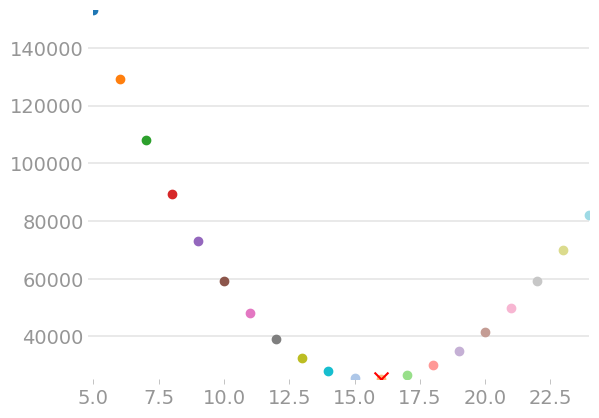

In [135]:
r = 35; a = 17.3+r; b = 18.8+r; ri = 4.5 # measure from images
err = 1e5 # initial error
for c_temp in range(5, 25):
    dx = traj.x - a; dy = traj.y - b; dz = traj.z - c_temp
    temp_err = (((dx**2 + dy**2 + dz**2)**0.5 - (r-ri))**2).sum()
    plt.scatter(c_temp, temp_err)
    if err > temp_err:
        err = temp_err
        c = c_temp
plt.scatter(c, err, s=100, marker='x', c='red')
p = {'a': a, 'b': b, 'c': c, 'r': r}
print(p)

#### 3.2.2 Rotation view, outer drop reference (3d-traj-RVRef.avi)

<font color='red'> NOTE: run one of the cells in 3.2.1 to get p before running the cell below

In [136]:
save_folder = os.path.join(folder, 'crop_HoughCircles', '3d-traj-RVRef')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)

a, b, c, r = p['a'], p['b'], p['c'], p['r'] # 

for n, i in traj.iterrows():
    if n % 10 == 0:
        print('{0:d}/{1:d}, {2:.2f}%'.format(n, len(traj), n/len(traj)*100))
        fig = plt.figure(figsize=(3, 3), dpi=300)
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim([a-r, a+r])
        ax.set_ylim([b+r, b-r])        
        ax.set_zlim([c-r, c+r])
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = r*np.cos(u)*np.sin(v) + a
        y = r*np.sin(u)*np.sin(v) + b
        z = r*np.cos(v) + c
        ax.plot_wireframe(x, y, z, color=(1, 0, 0, 0.3), lw=0.5, ls='--')
        ax.axis('off')
        ax.plot(traj.x[:n], traj.y[:n], traj.z[:n], color='black', lw=0.5, ls='-.')
        ax.scatter(traj.x[n], traj.y[n], traj.z[n], s=20, marker='o', color=bestcolor(1))
        ax.view_init(30, 360*n/len(traj))
        fig.savefig(os.path.join(save_folder, '{:04d}.jpg'.format(n)))
        plt.close()
        clear_output(wait=True)

1800/1803, 99.83%
